### Convert df_events to meta dataframe for pyphotometry analysis
- Meant to be a bridge between the pyphotometry analysis and df_events for the time being 

In [96]:
%reload_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import numpy as np
from trialexp.process.pycontrol.session_analysis import *

In [86]:
df_events = pd.read_pickle('df_events.pkl')

### Read task definition

In [32]:
basefolder = r'C:\code\trialexp'
tasks = pd.read_csv(basefolder+'\\params\\tasks_params.csv', usecols=[1, 2, 3, 4], index_col=False)

In [33]:
from trialexp.process.pycontrol.session_analysis import Session

In [34]:
conditions, triggers = Session.get_task_specs(tasks, 'reaching_go_spout_incr_break2_nov22')

# extract condition from the event list
df_conditions = df_events[df_events.event_name.isin(conditions)]
df_conditions.set_index('time', inplace=True, drop=True)
df_conditions

,state,event_name,trial_number
time,,,
45.571,waiting_for_spout,spout,1
45.591,busy_win,US_end_timer,1
45.593,busy_win,US_end_timer,1
61.650,waiting_for_spout,spout,2
61.671,busy_win,US_end_timer,2
...,...,...,...
193.255,busy_win,US_end_timer,18
196.526,waiting_for_spout,spout,19
196.547,busy_win,US_end_timer,19


In [108]:
trial_window = [-2, 4] # time window around trigger where data are considered to be the same trial 

trigger_time = df_events[(df_events.state.isin(triggers)) & (df_events.event_name == 'state_change')].time
df_events = add_trial_nb(df_events, trigger_time,trial_window)
df_events = add_time_rel_trigger(df_events, trigger_time, 'trial_time', trial_window)
df_events

,state,event_name,time,trial_number,trial_nb,trial_time
1,short_break,state_change,0.000,0,NaN,NaN
2,short_break,bar_off,0.345,0,NaN,NaN
3,short_break,bar,0.425,0,NaN,NaN
4,short_break,bar_off,0.795,0,NaN,NaN
5,short_break,bar,1.292,0,NaN,NaN
...,...,...,...,...,...,...
550,busy_win,bar,201.003,20,20.0,1.817
551,busy_win,bar_off,201.085,20,20.0,1.899
552,busy_win,bar,201.102,20,20.0,1.916
553,busy_win,bar_off,201.118,20,20.0,1.932


<AxesSubplot: xlabel='trial_time', ylabel='trial_nb'>

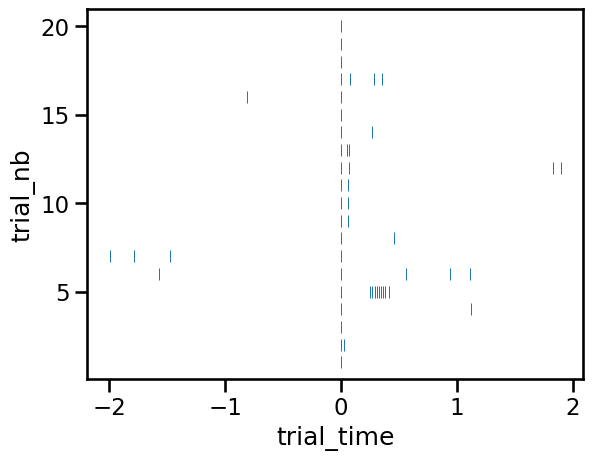

In [109]:
df2plot = df_events[df_events.event_name=='spout']
sns.scatterplot(y='trial_nb', x='trial_time', marker='|', data=df2plot)

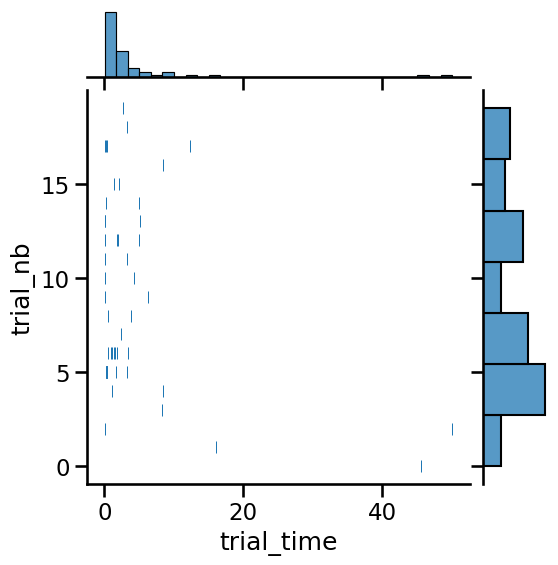

In [65]:
sns.set_context('talk')
sns.jointplot(x='trial_time', y='trial_nb', marker='|',data=df2plot)